In [25]:
# import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import re
#import random
#from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
#from string import ascii_letters
import seaborn as sns
import h5py as h5

#from string import ascii_letters

In [26]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [79]:
df =pd.read_pickle('../pickle_pd/pd_top_25.pkl')
features = ['lep_pt_2','met_et','lep_pt_1','jet_n','lep_E_1','jet_pt_0','lep_eta_0','jet_pt_1','lep_pt_0','lep_E_2','lep_eta_1','lep_phi_1','lep_phi_0',
            'lep_ptcone30_1','lep_ptcone30_0','jet_eta_0','jet_m','lep_E_0','jet_eta_1','jet_pt_2','lep_pt_3','jet_E_0','lep_charge_1','lep_charge_0','lep_E_3']

In [81]:
y = df.pop('label')

In [82]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = tf.keras.utils.to_categorical(y_encoded)

In [6]:
len(list(df))

25

In [83]:
 X_train, X_test, y_train, y_test = train_test_split( df[features], y_one_hot, test_size=0.4, random_state=42,shuffle = True)
 X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42,shuffle = True)

In [8]:
space={#'dimension': hp.uniform("dimension", 64, 256),
        'learning_rate': hp.uniform ('learning_rate', 0.0005,0.005),
        'beta_1' : hp.uniform('beta_1', 0.5,0.99),
        'beta_2' : hp.uniform('beta_2', 0.8,0.9999),
        'epsilon' : hp.uniform('epsilon', 1e-08,1e-06),
        'ema_momentum' : hp.uniform('ema_momentum', 0.8, 0.999),
        'dropout' : hp.uniform('dropout', 0,0.5)
    }

In [13]:
def objective(space):
    optimizer = Adam(learning_rate=space['learning_rate'], beta_1=space['beta_1'], beta_2=space['beta_2'], epsilon=space['epsilon'], ema_momentum=space['ema_momentum'])
                
    model = Sequential([
            Dense(128, activation='relu', input_dim=24),
                Dropout(space['dropout']),
            Dense(64, activation='relu'),
                #Dropout(space['dropout']),
            Dense(32, activation='relu'),
                #Dropout(space['dropout']),
            Dense(3, activation='softmax')
            ])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    #model.fit(X_train, y_train,
    #        eval_set=evaluation, #eval_metric="auc",
    #        early_stopping_rounds=10,verbose=False)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    fit_results = model.fit(
              x=X_train,
              y=y_train,
              batch_size=512,
              epochs=65,
              validation_data=(X_test, y_test),
              #callbacks=[checkpoint],
              verbose=0
            )
    

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [22]:
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0005), np.log(0.005)),
    'beta_1': hp.uniform('beta_1', 0.5, 0.99),
    'beta_2': hp.uniform('beta_2', 0.8, 0.9999),
    'epsilon': hp.loguniform('epsilon', np.log(1e-08), np.log(1e-06)),
    'ema_momentum': hp.uniform('ema_momentum', 0.8, 0.999),
    'dropout': hp.uniform('dropout', 0, 0.5)
}

def objective(space):
    optimizer = Adam(
        learning_rate=space['learning_rate'],
        beta_1=space['beta_1'],
        beta_2=space['beta_2'],
        epsilon=space['epsilon'],
    )
                
    model = Sequential([
        Dense(128, activation='relu', input_dim=24),
        Dropout(space['dropout']),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    fit_results = model.fit(
        x=X_train,
        y=y_train,
        batch_size=512,
        epochs=65,
        validation_data=(X_test, y_test),
        verbose=0
    )

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print("SCORE:", accuracy)
    
    return {'loss': -accuracy, 'status': 'ok'}

# Assuming you have defined X_train, y_train, X_test, y_test

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best hyperparameters:", best)

  0%|                            | 0/50 [00:00<?, ?trial/s, best loss=?]

1628/1628 [==============================] - 0s 213us/step             

SCORE:                                                                  
0.0                                                                     
  2%|▎               | 1/50 [00:54<44:26, 54.42s/trial, best loss: -0.0]

1628/1628 [==============================] - 0s 217us/step             

SCORE:                                                                  
0.7273914462944825                                                      
  4%| | 2/50 [01:49<43:47, 54.75s/trial, best loss: -0.7273914462944825]

1628/1628 [==============================] - 0s 217us/step             

SCORE:                                                                  
0.0                                                                     
  6%| | 3/50 [02:43<42:38, 54.45s/trial, best loss: -0.7273914462944825]

1628/1628 [==============================] - 0s 217us/step             

SCORE:                                                                  
0.7126039446140846                                                      
  8%| | 4/50 [03:37<41:44, 54.45s/trial, best loss: -0.7273914462944825]

1628/1628 [==============================] - 0s 221us/step             

SCORE:                                                                  
0.6926504196193659                                                      
 10%| | 5/50 [04:33<41:05, 54.80s/trial, best loss: -0.7273914462944825]

1628/1628 [==============================] - 0s 211us/step             

SCORE:                                                                  
0.0                                                                     
 12%| | 6/50 [05:27<40:04, 54.65s/trial, best loss: -0.7273914462944825]

1628/1628 [==============================] - 0s 207us/step             

SCORE:                                                                  
0.715100535806879                                                       
 14%|▏| 7/50 [06:21<39:02, 54.48s/trial, best loss: -0.7273914462944825]

1628/1628 [==============================] - 0s 206us/step             

SCORE:                                                                  
0.6974131474333122                                                      
 16%|▏| 8/50 [07:16<38:09, 54.51s/trial, best loss: -0.7273914462944825]

1628/1628 [==============================] - 0s 213us/step             

SCORE:                                                                  
0.7158495131647175                                                      
 18%|▏| 9/50 [08:09<36:54, 54.00s/trial, best loss: -0.7273914462944825]

1628/1628 [==============================] - 0s 218us/step             

SCORE:                                                                  
0.0                                                                     
 20%|▏| 10/50 [09:04<36:08, 54.22s/trial, best loss: -0.7273914462944825

1628/1628 [==============================] - 0s 220us/step             

SCORE:                                                                  
0.7187878089531601                                                      
 22%|▏| 11/50 [09:59<35:27, 54.55s/trial, best loss: -0.7273914462944825

1628/1628 [==============================] - 0s 217us/step             

SCORE:                                                                  
0.682183941157266                                                       
 24%|▏| 12/50 [10:54<34:37, 54.67s/trial, best loss: -0.7273914462944825

1628/1628 [==============================] - 0s 215us/step             

SCORE:                                                                  
0.6869850780664861                                                      
 26%|▎| 13/50 [11:49<33:45, 54.75s/trial, best loss: -0.7273914462944825

1628/1628 [==============================] - 0s 246us/step             

SCORE:                                                                  
0.7170401951182039                                                      
 28%|▎| 14/50 [12:45<33:06, 55.17s/trial, best loss: -0.7273914462944825

1628/1628 [==============================] - 0s 218us/step             

SCORE:                                                                  
0.6929192832862822                                                      
 30%|▎| 15/50 [13:41<32:23, 55.52s/trial, best loss: -0.7273914462944825

1628/1628 [==============================] - 0s 220us/step             

SCORE:                                                                  
0.682510418467093                                                       
 32%|▎| 16/50 [14:37<31:30, 55.61s/trial, best loss: -0.7273914462944825

1628/1628 [==============================] - 0s 223us/step             

SCORE:                                                                  
0.7211307637648595                                                      
 34%|▎| 17/50 [15:34<30:53, 56.17s/trial, best loss: -0.7273914462944825

1628/1628 [==============================] - 0s 219us/step             

SCORE:                                                                  
0.7065545121084673                                                      
 36%|▎| 18/50 [16:30<29:53, 56.06s/trial, best loss: -0.7273914462944825

1628/1628 [==============================] - 0s 222us/step             

SCORE:                                                                  
0.7276987190566726                                                      
 38%|▍| 19/50 [17:26<28:57, 56.06s/trial, best loss: -0.7276987190566726

1628/1628 [==============================] - 0s 222us/step             

SCORE:                                                                  
0.7204394000499318                                                      
 40%|▍| 20/50 [18:23<28:05, 56.19s/trial, best loss: -0.7276987190566726

1628/1628 [==============================] - 0s 220us/step             

SCORE:                                                                  
0.19696184056384552                                                     
 42%|▍| 21/50 [19:20<27:14, 56.38s/trial, best loss: -0.7276987190566726

1628/1628 [==============================] - 0s 221us/step             

SCORE:                                                                  
0.7445603118818537                                                      
 44%|▍| 22/50 [20:17<26:23, 56.56s/trial, best loss: -0.7445603118818537

1628/1628 [==============================] - 0s 227us/step             

SCORE:                                                                  
0.14121103877398167                                                     
 46%|▍| 23/50 [21:15<25:38, 56.99s/trial, best loss: -0.7445603118818537

1628/1628 [==============================] - 0s 228us/step             

SCORE:                                                                  
0.711259626279503                                                       
 48%|▍| 24/50 [22:12<24:46, 57.19s/trial, best loss: -0.7445603118818537

1628/1628 [==============================] - 0s 227us/step             

SCORE:                                                                  
0.7333832651571892                                                      
 50%|▌| 25/50 [23:10<23:53, 57.36s/trial, best loss: -0.7445603118818537

1628/1628 [==============================] - 0s 228us/step             

SCORE:                                                                  
0.7212651955983177                                                      
 52%|▌| 26/50 [24:08<22:59, 57.47s/trial, best loss: -0.7445603118818537

1628/1628 [==============================] - 0s 227us/step             

SCORE:                                                                  
0.7247220141729561                                                      
 54%|▌| 27/50 [25:05<22:01, 57.45s/trial, best loss: -0.7445603118818537

1628/1628 [==============================] - 0s 227us/step             

SCORE:                                                                  
0.7327303105375352                                                      
 56%|▌| 28/50 [26:03<21:09, 57.70s/trial, best loss: -0.7445603118818537

1628/1628 [==============================] - 0s 230us/step             

SCORE:                                                                  
0.7467304257648211                                                      
 58%|▌| 29/50 [27:02<20:18, 58.04s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 1s 313us/step             

SCORE:                                                                  
0.730848264869121                                                       
 60%|▌| 30/50 [28:01<19:24, 58.22s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 232us/step             

SCORE:                                                                  
0.0                                                                     
 62%|▌| 31/50 [28:59<18:23, 58.09s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 230us/step             

SCORE:                                                                  
0.03664227689116783                                                     
 64%|▋| 32/50 [29:57<17:26, 58.15s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 231us/step             

SCORE:                                                                  
0.6936106470012099                                                      
 66%|▋| 33/50 [30:56<16:35, 58.54s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 231us/step             

SCORE:                                                                  
0.7331144014902728                                                      
 68%|▋| 34/50 [31:56<15:39, 58.71s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 252us/step             

SCORE:                                                                  
0.7137562174722974                                                      
 70%|▋| 35/50 [32:55<14:45, 59.04s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 234us/step             

SCORE:                                                                  
0.0                                                                     
 72%|▋| 36/50 [33:56<13:52, 59.46s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 232us/step             

SCORE:                                                                  
0.7250869005780569                                                      
 74%|▋| 37/50 [34:55<12:53, 59.48s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 233us/step             

SCORE:                                                                  
0.7132376946861017                                                      
 76%|▊| 38/50 [35:55<11:53, 59.46s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 243us/step             

SCORE:                                                                  
0.6892128055923643                                                      
 78%|▊| 39/50 [36:54<10:54, 59.53s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 246us/step             

SCORE:                                                                  
0.7215724683605078                                                      
 80%|▊| 40/50 [37:59<10:09, 60.96s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 254us/step             

SCORE:                                                                  
0.6941099652397688                                                      
 82%|▊| 41/50 [39:03<09:17, 61.96s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 229us/step             

SCORE:                                                                  
0.033550344721630085                                                    
 84%|▊| 42/50 [40:04<08:13, 61.67s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 231us/step             

SCORE:                                                                  
0.7120278081849782                                                      
 86%|▊| 43/50 [41:04<07:08, 61.26s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 230us/step             

SCORE:                                                                  
0.6581782566111655                                                      
 88%|▉| 44/50 [42:04<06:05, 60.87s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 232us/step             

SCORE:                                                                  
0.7345739471106758                                                      
 90%|▉| 45/50 [43:04<05:03, 60.61s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 240us/step             

SCORE:                                                                  
0.6914597376658793                                                      
 92%|▉| 46/50 [44:05<04:02, 60.54s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 243us/step             

SCORE:                                                                  
0.732442242322982                                                       
 94%|▉| 47/50 [45:05<03:01, 60.62s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 239us/step             

SCORE:                                                                  
0.7083981486816078                                                      
 96%|▉| 48/50 [46:06<02:00, 60.49s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 1s 338us/step             

SCORE:                                                                  
0.6900386011407501                                                      
 98%|▉| 49/50 [47:06<01:00, 60.37s/trial, best loss: -0.7467304257648211

1628/1628 [==============================] - 0s 230us/step             

SCORE:                                                                  
0.0                                                                     
100%|█| 50/50 [48:07<00:00, 57.74s/trial, best loss: -0.7467304257648211
Best hyperparameters: {'beta_1': 0.6012115429597784, 'beta_2': 0.8342016359854416, 'dropout': 0.00956185724776542, 'ema_momentum': 0.9425072341735632, 'epsilon': 1.5092638258743137e-07, 'learning_rate': 0.001234077866108187}


In [14]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 25,
                        trials = trials)

  0%|                            | 0/25 [00:00<?, ?trial/s, best loss=?]

1628/1628 [==============================] - 1s 341us/step             

SCORE:                                                                  
0.7108179216838547                                                      
  4%| | 1/25 [01:32<36:59, 92.46s/trial, best loss: -0.7108179216838547]

1628/1628 [==============================] - 1s 320us/step             

SCORE:                                                                  
0.0                                                                     
  8%| | 2/25 [02:55<33:22, 87.07s/trial, best loss: -0.7108179216838547]

1628/1628 [==============================] - 1s 339us/step             

SCORE:                                                                  
0.7021566706996216                                                      
 12%| | 3/25 [04:28<32:50, 89.56s/trial, best loss: -0.7108179216838547]

1628/1628 [==============================] - 1s 338us/step             

SCORE:                                                                  
0.7289470146530699                                                      
 16%|▏| 4/25 [05:56<31:10, 89.08s/trial, best loss: -0.7289470146530699]

1628/1628 [==============================] - 1s 346us/step             

SCORE:                                                                  
0.2052197960477041                                                      
 20%|▏| 5/25 [07:24<29:33, 88.67s/trial, best loss: -0.7289470146530699]

1628/1628 [==============================] - 1s 342us/step             

SCORE:                                                                  
0.0                                                                     
 24%|▏| 6/25 [08:52<28:01, 88.50s/trial, best loss: -0.7289470146530699]

1628/1628 [==============================] - 1s 351us/step             

SCORE:                                                                  
0.7115476944940562                                                      
 28%|▎| 7/25 [10:24<26:49, 89.44s/trial, best loss: -0.7289470146530699]

1628/1628 [==============================] - 1s 345us/step             

SCORE:                                                                  
0.6917478058804325                                                      
 32%|▎| 8/25 [11:53<25:18, 89.35s/trial, best loss: -0.7289470146530699]

1628/1628 [==============================] - 1s 358us/step             

SCORE:                                                                  
0.6949933744310652                                                      
 36%|▎| 9/25 [13:22<23:48, 89.31s/trial, best loss: -0.7289470146530699]

1628/1628 [==============================] - 1s 344us/step             

SCORE:                                                                  
0.7240882641009391                                                      
 40%|▍| 10/25 [14:52<22:22, 89.49s/trial, best loss: -0.7289470146530699

1628/1628 [==============================] - 1s 392us/step             

SCORE:                                                                  
0.0                                                                     
 44%|▍| 11/25 [16:28<21:21, 91.50s/trial, best loss: -0.7289470146530699

1628/1628 [==============================] - 1s 384us/step             

SCORE:                                                                  
0.7211883774077702                                                      
 48%|▍| 12/25 [18:08<20:21, 93.96s/trial, best loss: -0.7289470146530699

1628/1628 [==============================] - 1s 352us/step             

SCORE:                                                                  
0.6929192832862822                                                      
 52%|▌| 13/25 [19:47<19:07, 95.65s/trial, best loss: -0.7289470146530699

1628/1628 [==============================] - 1s 341us/step             

SCORE:                                                                  
0.0                                                                     
 56%|▌| 14/25 [21:17<17:12, 93.83s/trial, best loss: -0.7289470146530699

1628/1628 [==============================] - 1s 363us/step             

SCORE:                                                                  
0.20253115937854083                                                     
 60%|▌| 15/25 [22:47<15:27, 92.76s/trial, best loss: -0.7289470146530699

1628/1628 [==============================] - 1s 525us/step             

SCORE:                                                                  
0.6938603061204893                                                      
 64%|▋| 16/25 [24:19<13:54, 92.68s/trial, best loss: -0.7289470146530699

1628/1628 [==============================] - 1s 456us/step             

SCORE:                                                                  
0.0                                                                     
 68%|▋| 17/25 [26:03<12:46, 95.84s/trial, best loss: -0.7289470146530699

1628/1628 [==============================] - 1s 459us/step             

SCORE:                                                                  
0.6816654183710703                                                      
 72%|▋| 18/25 [27:53<11:40, 100.07s/trial, best loss: -0.728947014653069

1628/1628 [==============================] - 0s 256us/step             

SCORE:                                                                  
0.2055078642622573                                                      
 76%|▊| 19/25 [30:27<11:38, 116.36s/trial, best loss: -0.728947014653069

1628/1628 [==============================] - 0s 261us/step             

SCORE:                                                                  
0.7268153098653761                                                      
 80%|▊| 20/25 [31:33<08:26, 101.27s/trial, best loss: -0.728947014653069

1628/1628 [==============================] - 1s 486us/step             

SCORE:                                                                  
0.7048068982735112                                                      
 84%|▊| 21/25 [33:21<06:53, 103.43s/trial, best loss: -0.728947014653069

1628/1628 [==============================] - 1s 414us/step             

SCORE:                                                                  
0.7294847419869025                                                      
 88%|▉| 22/25 [35:04<05:09, 103.19s/trial, best loss: -0.729484741986902

1628/1628 [==============================] - 1s 427us/step             

SCORE:                                                                  
0.7255862188166158                                                      
 92%|▉| 23/25 [36:40<03:21, 100.92s/trial, best loss: -0.729484741986902

1628/1628 [==============================] - 1s 382us/step             

SCORE:                                                                  
0.7219373547656085                                                      
 96%|▉| 24/25 [38:22<01:41, 101.39s/trial, best loss: -0.729484741986902

1628/1628 [==============================] - 1s 382us/step             

SCORE:                                                                  
0.0                                                                     
100%|█| 25/25 [40:03<00:00, 96.15s/trial, best loss: -0.7294847419869025


In [10]:
best

{'beta_1': 0.6012115429597784,
 'beta_2': 0.8342016359854416,
 'dropout': 0.00956185724776542,
 'ema_momentum': 0.9425072341735632,
 'epsilon': 1.5092638258743137e-07,
 'learning_rate': 0.001234077866108187}

In [27]:
best = {'beta_1': 0.6012115429597784,
 'beta_2': 0.8342016359854416,
 'dropout': 0.00956185724776542,
 'ema_momentum': 0.9425072341735632,
 'epsilon': 1.5092638258743137e-07,
 'learning_rate': 0.001234077866108187}

In [15]:
best_hyperparams

{'beta_1': 0.5054678031646203,
 'beta_2': 0.9483840596795294,
 'dropout': 0.014560133610613937,
 'ema_momentum': 0.9279838218799413,
 'epsilon': 5.334404280334826e-07,
 'learning_rate': 0.0022920443441381737}

In [15]:
%load_ext tensorboard
import tensorboard
tensorboard.__version__
from datetime import datetime
import tensorflow.keras as keras
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [85]:
NN_model = Sequential([
            Dense(128, activation='relu', input_dim=25),
                Dropout(best['dropout']),
            Dense(64, activation='relu'),
                #Dropout(space['dropout']),
            Dense(32, activation='relu'),
                #Dropout(space['dropout']),
            Dense(3, activation='softmax')
            ])

optimizer = Adam(learning_rate=best['learning_rate'], beta_1=best['beta_1'], beta_2=best['beta_2'], epsilon=best['epsilon'], ema_momentum=best['ema_momentum'])
NN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = NN_model.fit(
              x=X_train,
              y=y_train,
              batch_size=512,
              epochs=130,
              validation_data=(X_test, y_test),
              #callbacks=[checkpoint],
              verbose=0,
                callbacks=[tensorboard_callback]
            )

In [19]:
%tensorboard --logdir logs

In [ ]:
!tensorboard dev upload \
  --logdir logs \
  --name "Sample op-level graph" \
  --one_shot

In [ ]:
%load_ext tensorboard

In [ ]:
import tensorboard
tensorboard.__version__

In [ ]:
NN_model

In [ ]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [17]:
NN_model = Sequential([
            Dense(128, activation='relu', input_dim=24),
                Dropout(best_hyperparams['dropout']),
            Dense(64, activation='relu'),
                #Dropout(space['dropout']),
            Dense(32, activation='relu'),
                #Dropout(space['dropout']),
            Dense(3, activation='softmax')
            ])

optimizer = Adam(learning_rate=best_hyperparams['learning_rate'], beta_1=best_hyperparams['beta_1'], beta_2=best_hyperparams['beta_2'], epsilon=best_hyperparams['epsilon'], ema_momentum=best_hyperparams['ema_momentum'])
NN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = NN_model.fit(
              x=X_train,
              y=y_train,
              batch_size=512,
              epochs=65,
              validation_data=(X_test, y_test),
              #callbacks=[checkpoint],
              verbose=0
            )

y_pred = NN_model.predict(X_test)

1628/1628 [==============================] - 1s 453us/step


In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

(0.0, 2.0)

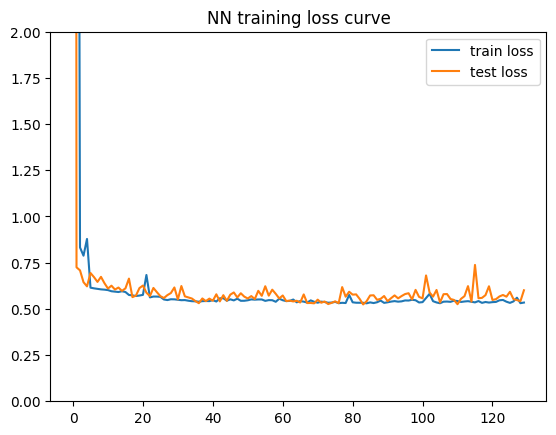

In [41]:
plt.plot(history.history['loss'],label = 'train loss')
plt.plot(history.history['val_loss'],label = 'test loss')
plt.title('NN training loss curve')
plt.legend()
plt.ylim(0,2)

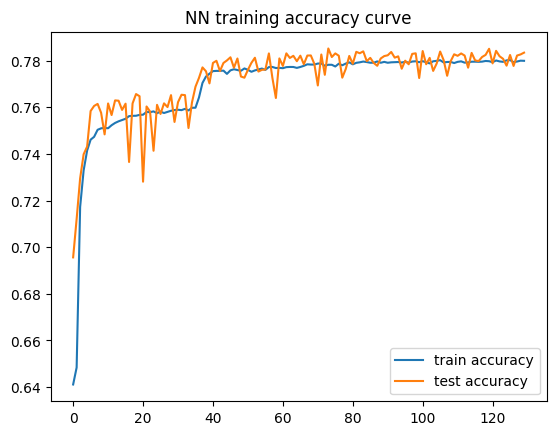

In [42]:
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.title('NN training accuracy curve')
plt.legend()

In [96]:
y_pred = NN_model.predict(X_test)

1628/1628 [==============================] - 7s 4ms/step


In [97]:
y_pred.shape

(52071, 3)

In [98]:
y_pred[0]

array([0.38784254, 0.38291648, 0.22924091], dtype=float32)

In [27]:
y_pred = np.argmax(y_pred,axis=1)

In [100]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
y_test = np.argmax(y_test,axis=1)

In [22]:
y_test

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

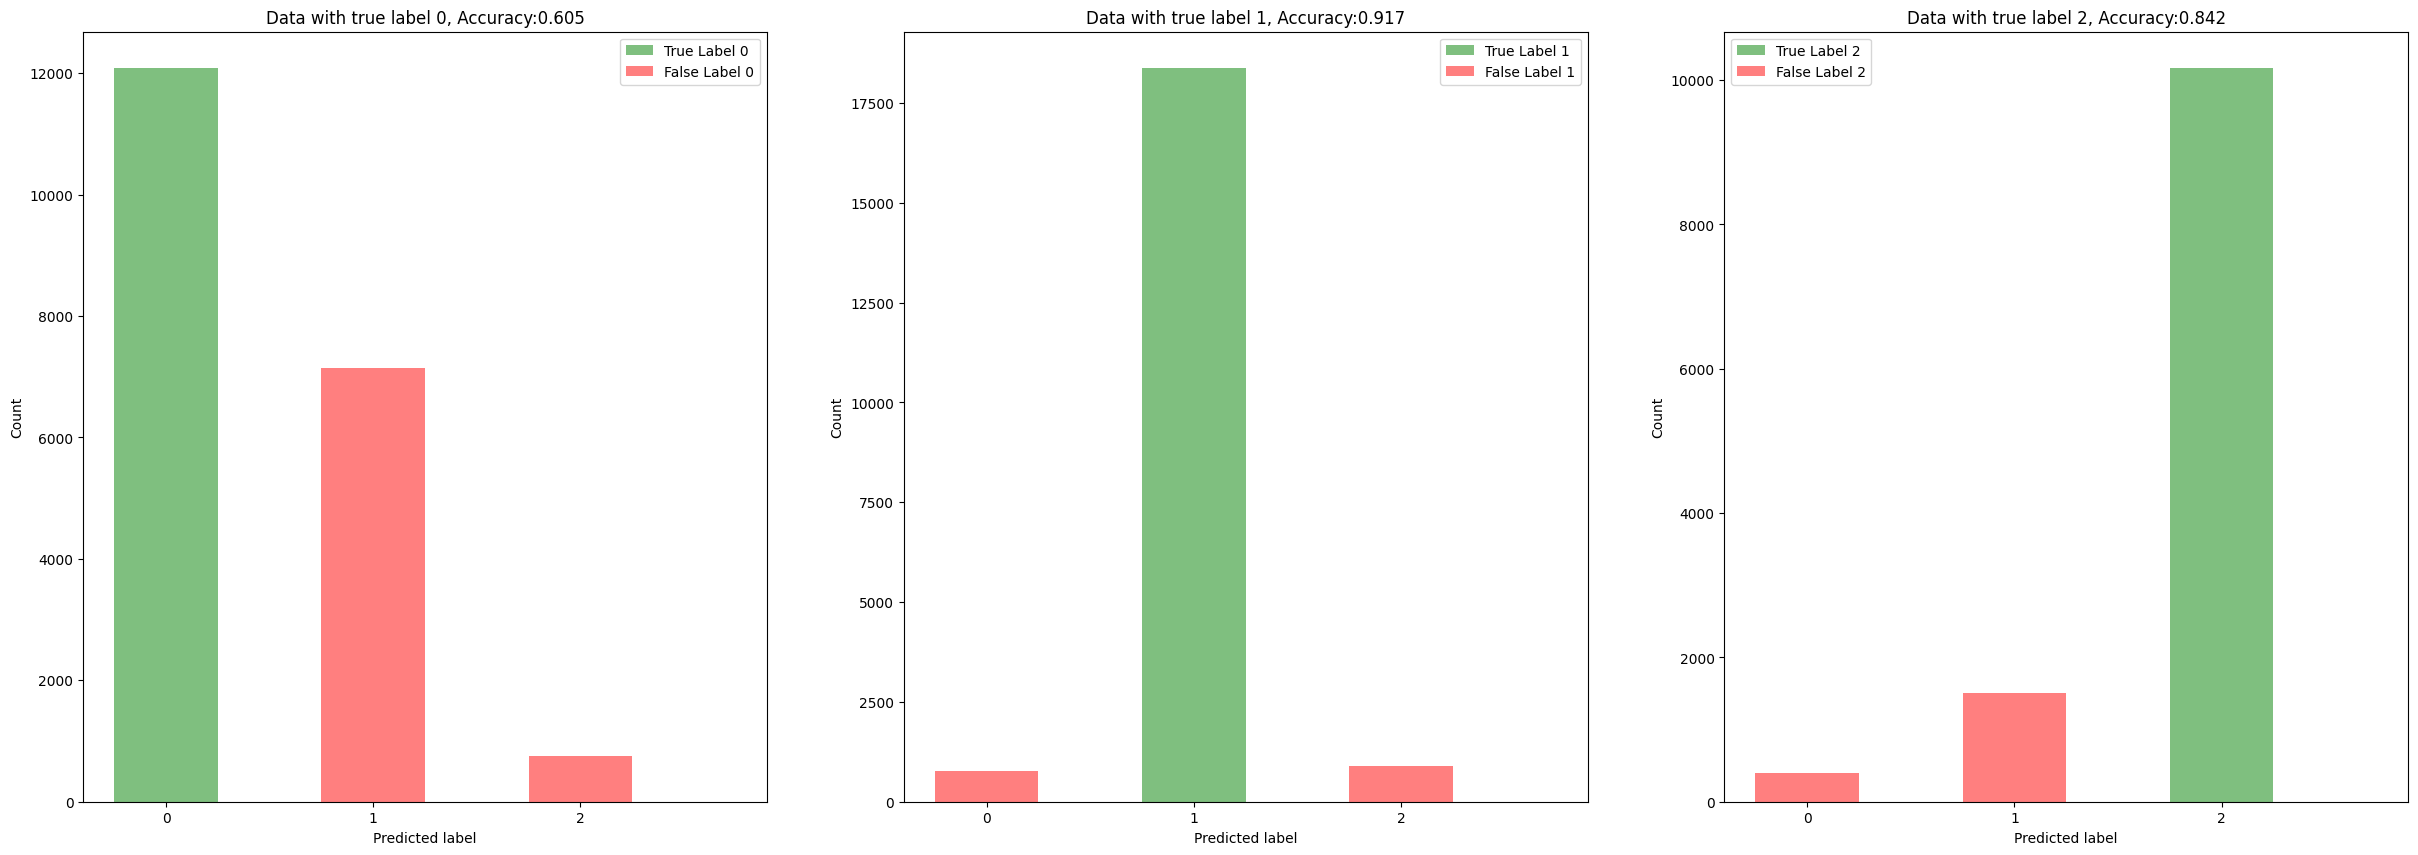

In [29]:
bins = [-0.25, 0.75, 1.75, 2.75] 
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i, label in enumerate(range(3)):
    test_label = y_test[y_test==label]
    pred_label = y_pred[y_test==label]
    true_label = pred_label[pred_label == test_label]
    false_label= pred_label[pred_label != test_label]
    #print(len(false_label))
    ax[i].hist(true_label , bins = bins, histtype = 'barstacked', alpha=0.5, label='True Label ' + str(label), align = 'mid', width = 0.5, color = 'green')
    ax[i].hist(false_label, bins = bins, histtype = 'barstacked', alpha=0.5, label='False Label ' + str(label), align = 'mid', width = 0.5, color = 'red')
    #ax[i] = plt.xlabel('label')
    ax[i].set_title(f'Data with true label {i}, Accuracy:{accuracy_score(test_label, pred_label):.3f}')
    ax[i].set_xlabel(xlabel = f'Predicted label')
    ax[i].set_ylabel('Count')
    ax[i].legend()
    ax[i].set_xticks(range(3))

In [86]:
y_pred = NN_model.predict(X_val)
y_pred_train = NN_model.predict(X_train)

9764/9764 [==============================] - 2s 222us/step


In [87]:
X_test.shape

(104141, 25)

In [88]:
y_pred[0]

array([0.00282543, 0.07427823, 0.9228963 ], dtype=float32)

In [89]:
for i in range(y_pred.shape[0]):
    n = np.argmax(y_pred[i])
    y_pred[i] = [0,0,0]
    y_pred[i][n] = 1


In [90]:
for i in range(y_pred_train.shape[0]):
    n = np.argmax(y_pred_train[i])
    y_pred_train[i] = [0,0,0]
    y_pred_train[i][n] = 1

In [91]:
y_pred = np.argmax(y_pred,axis=1)
y_pred_train = np.argmax(y_pred_train,axis=1)
y_train = np.argmax(y_train, axis =1)
y_val = np.argmax(y_val, axis =1)

In [77]:
y_train = np.argmax(y_train, axis =1)
y_val = np.argmax(y_val, axis =1)

In [56]:
y_train = np.argmax(y_train, axis =1)

In [51]:
y_val = np.argmax(y_val, axis =1)

In [53]:
y_pred_train.shape

(52071,)

In [59]:
y_train[y_train==0].shape

(160064,)

In [61]:
y_pred_train.shape

(52071,)

In [54]:
y_val.shape

(52071,)

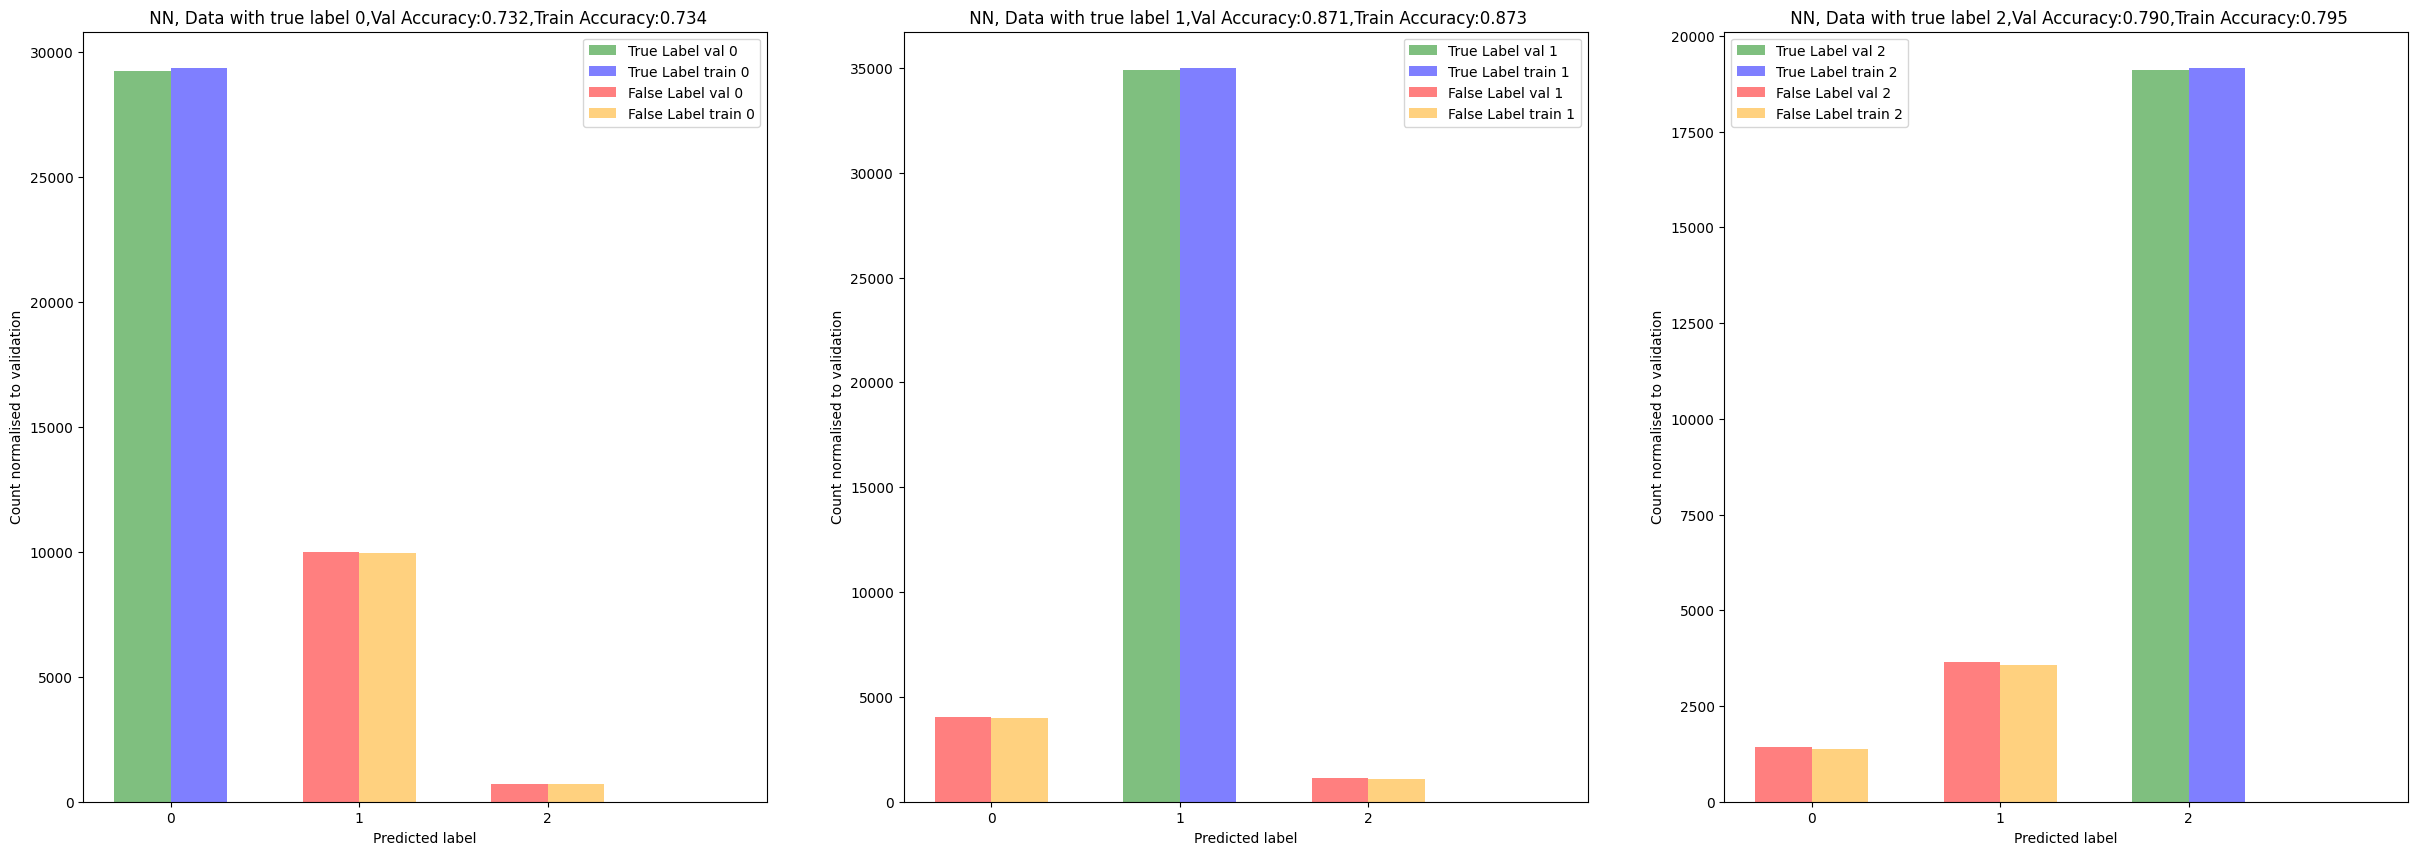

In [93]:
bins = [-0.3, 0.7, 1.7, 2.7] 
bins2 = [0, 1, 2, 3] 
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i, label in enumerate(range(3)):
    test_label = y_val[y_val==label]
    pred_label = y_pred[y_val==label]
    true_label = pred_label[pred_label == test_label]
    false_label= pred_label[pred_label != test_label]
    
    test_label_t = y_train[y_train==label]
    pred_label_t = y_pred_train[y_train==label]
    true_label_t = pred_label_t[pred_label_t == test_label_t]
    false_label_t= pred_label_t[pred_label_t != test_label_t]
    #print(len(false_label))
    ax[i].hist(true_label , bins = bins, histtype = 'barstacked', alpha=0.5, label='True Label val ' + str(label), align = 'mid', width = 0.3, color = 'green')
    ax[i].hist(true_label_t[0:int(round(len(true_label_t)/3,0))] , bins = bins2, histtype = 'barstacked', alpha=0.5, label='True Label train ' + str(label), align = 'mid', width = 0.3, color = 'blue') 
    ax[i].hist(false_label, bins = bins, histtype = 'barstacked', alpha=0.5, label='False Label val ' + str(label), align = 'mid', width = 0.3, color = 'red')
    ax[i].hist(false_label_t[0:int(round(len(false_label_t)/3,0))], bins = bins2, histtype = 'barstacked', alpha=0.5, label='False Label train ' + str(label), align = 'mid', width = 0.3, color = 'orange')
    #ax[i] = plt.xlabel('label')
    ax[i].set_title(f' NN, Data with true label {i},Val Accuracy:{accuracy_score(test_label, pred_label):.3f},Train Accuracy:{accuracy_score(test_label_t, pred_label_t):.3f}')
    ax[i].set_xlabel(xlabel = f'Predicted label')
    ax[i].set_ylabel('Count normalised to validation')
    ax[i].legend()
    ax[i].set_xticks(range(3))